In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from PIL import Image, ImageFont, ImageDraw
font = ImageFont.truetype("arialbd.ttf", size=40)

left_fitx = 0
right_fitx = 0
ploty = 0
left_fit = 0
right_fit = 0


In [2]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
def corners_warp(img, nx, ny,action):
    offset = 100
    img_size = (img.shape[1], img.shape[0])
    #for chessboard
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
   
    #for full/half lanes
    src = np.float32([[278,704],[600,453],(727,453),[1111,704]])
    # for half lanes covering the full image
    dst = np.float32([[278,704],[278,0],[1111,0],[1111,704]])
    # for full lanes covering the full image
    #dst = np.float32([[278,704],[278,453],[1111,453],[1111,704]])
    if action is 'warp':
        M = cv2.getPerspectiveTransform(src, dst)
    elif action is 'unwarp':
        M = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

In [4]:
def fit_polynomial(leftx, lefty, rightx, righty, image):
  
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx,right_fitx,ploty , left_fit,right_fit


In [5]:
def blind_lane_search(binary_warped):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int_(binary_warped.shape[0]//1.33):,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])       # save the highest point location on left side for base
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint   # save the highest point location on left side for base

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 7
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_coordinates = np.nonzero(binary_warped) #CHECK IF THIS IS OKAY
    nonzeroy = np.array(nonzero_coordinates[0])
    nonzerox = np.array(nonzero_coordinates[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current-margin  
        win_xright_high = rightx_current+margin  

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox <= win_xleft_high)).nonzero()[0] # just taking x coordinates
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox <= win_xright_high)).nonzero()[0] # just taking x coordinates

        # Append these X indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### recenter next window if more pixels found that the minimum threshold ###
        if len(good_left_inds>1) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds>1) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx,right_fitx,ploty, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, binary_warped)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plot the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(out_img)
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

In [6]:
def focused_lane_search(binary_warped):# , left_fitx, right_fitx, ploty, left_fit, right_fit):
    margin = 100
        
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx_new,right_fitx_new,ploty_new , left_fit_new, right_fit_new = fit_polynomial(leftx, lefty, rightx, righty, binary_warped)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    left_lane_window1 = np.transpose([left_fitx_new-margin,ploty_new])
    left_lane_window2 = np.flipud(np.transpose([left_fitx_new+margin,ploty_new]))
    left_lane_points = np.vstack((left_lane_window1,left_lane_window2))
  
    right_lane_window1 = np.transpose([right_fitx_new-margin,ploty_new])
    right_lane_window2 = np.flipud(np.transpose([right_fitx_new+margin,ploty_new]))
    right_lane_points = np.vstack((right_lane_window1,right_lane_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_lane_points]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_lane_points]), (0,255, 0))
    
    #result_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   

    return window_img, left_fitx_new, right_fitx_new, ploty_new, left_fit_new, right_fit_new

In [7]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    
    ## Calculates the curvature of polynomial functions in meters.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty*ym_per_pix)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_radius = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_radius = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    avg_radius = ((left_radius+right_radius)/2).astype(int)
    radius_text_string = 'Radius of curvature = ' +str(avg_radius)+ '(m)'
    
    return radius_text_string

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    # Apply threshold
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))*180/np.pi
    dir_binary =  np.zeros_like(absgraddir)
    # Apply threshold
    dir_binary[(absgraddir <= thresh[0])] = 1# & (absgraddir >= thresh[1])] = 1

    return dir_binary

In [9]:
def offset_calculator(left_fitx,right_fitx,x_axis):
    

    xm_per_pix = 3.7/(right_fitx[-1] - left_fitx[-1]) # meters per pixel in x dimension
    lane_center = (right_fitx[-1] + left_fitx[-1] )//2
    camera_center = x_axis//2
    offset = np.around(xm_per_pix*(camera_center - lane_center),2)
    if (offset > 0):
        offset_text = 'Vehicle is ' + str(np.absolute(offset)) + 'm left of Center'
    elif (offset<=0):
        offset_text = 'Vehicle is ' + str(np.absolute(offset)) + 'm right of Center'
    
    return offset_text

In [24]:
def process_images (image):
    
    global left_fitx, right_fitx, ploty, left_fit, right_fit
    nx = 9
    ny = 6
    imgpoints = np.load('camera_imgpoints.npy')
    objpoints = np.load('camera_objpoints.npy')
    
    #fig.add_subplot(rows, columns, fig_num)
    fig_num=1
    #plt.imshow(image)
## UNDISTORT AND WARP THE ROAD IMAGES TO SEE THE LANES ##
    # CALIBRATE CAMERA
    undistorted = cal_undistort(image, objpoints, imgpoints)
    # Unwarp real images = make them straight
    
    warped_img,M = corners_warp(undistorted,nx,ny,'warp')
    
    # Choose a Sobel kernel size
    ksize = 9 # change it to 9 later # Choose a larger odd number to smooth gradient measurements

    # GRADIENT BASED LANE SEGREGATION
    gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY) #warped_img
    # Apply each of the thresholding functions    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=19, thresh=(20,135))

    # COLORSPACE BASED LANE SEGREGATION
    rgb = warped_img
    R = rgb[:,:,0]
    G = rgb[:,:,1]
    B = rgb[:,:,2]
    R_w_thresh = (220,255) 
    G_w_thresh = (220,255) 
    B_w_thresh = (215,255) 

    R_y_thresh = (130,255) 
    G_y_thresh = (130,255) 
    B_y_thresh = (0,120) 

    R_binary = np.zeros_like(R)
    R_binary[((R > R_w_thresh[0]) & (R <= R_w_thresh[1])) | ((R > R_y_thresh[0]) & (R <= R_y_thresh[1])) ] = 1
    G_binary = np.zeros_like(G)
    G_binary[((G > G_w_thresh[0]) & (G <= G_w_thresh[1])) | ((G > G_y_thresh[0]) & (G <= G_y_thresh[1])) ] = 1
    B_binary = np.zeros_like(B)
    B_binary[((B > B_w_thresh[0]) & (B <= B_w_thresh[1])) | ((B > B_y_thresh[0]) & (B <= B_y_thresh[1])) ] = 1
    
    combinedRGB = np.zeros_like(R_binary)
    combinedRGB[( (R_binary == 1) & (G_binary == 1) & (B_binary == 1)  )] = 1
    
    hls = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HSV)
    H = hls[:,:,0]
    S = hls[:,:,2]
    V = hsv[:,:,2]
    
    V_thresh = (0,255)
    V_binary = np.zeros_like(V)
    V_binary[(V > V_thresh[0]) & (V <= V_thresh[1])] = 1
    
    S_thresh = (180, 255)
    S_binary = np.zeros_like(S)
    S_binary[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1
    
    H_thresh = (15,60)#15,60 works
    H_binary = np.zeros_like(H)
    H_binary[(H > H_thresh[0]) & (H <= H_thresh[1])] = 1
    
    combined_HandSorX = np.zeros_like(H_binary)
    combined_HandSorX[( ((H_binary == 1) & (S_binary == 1) | (gradx == 1)))] = 1
    
    
    #final_combo = np.zeros_like(H_binary)
    #final_combo[(combined_HandSorX == 1) | (combinedRGB == 1)] = 1
    """fig.add_subplot(rows,columns, fig_num)
    fig_num+=1
    plt.title('R')
    plt.imshow(R_binary,cmap='gray')

    fig.add_subplot(rows,columns, fig_num)
    fig_num+=1
    plt.title('combines HSX')
    plt.imshow(combined_HandSorX,cmap='gray')
    """
    
    warp_zero = np.zeros_like(undistorted).astype(np.uint8)

    # Test whether variable is defined to be None
    if left_fitx is 0:
        lane_lines_defined,left_fitx,right_fitx,ploty,left_fit, right_fit = blind_lane_search(combined_HandSorX)
    else:
        lane_lines_defined,left_fitx,right_fitx,ploty,left_fit, right_fit = focused_lane_search(combined_HandSorX)#, left_fitx,right_fitx,ploty, left_fit, right_fit)
     
    image_with_lanes = cv2.addWeighted(warp_zero, 1, lane_lines_defined, 0.3, 0)
    
    
    right = np.transpose(np.array([right_fitx,ploty]))
    left = np.flipud(np.transpose(np.array([left_fitx,ploty])))
    
    poly_points = np.vstack((right,left))
    lane_poly = cv2.fillPoly(warp_zero, np.int_([poly_points]), (0,255, 0))
    #lane_poly = cv2.addWeighted(lane_poly,1,lane_lines_defined,.5,0)
    
    #right_lane_window1 = np.transpose([right_fitx_new-margin,ploty_new])
    #right_lane_window2 = np.flipud(np.transpose([right_fitx_new+margin,ploty_new]))
    #right_lane_points = np.vstack((right_lane_window1,right_lane_window2))
    
    unwarped_lanes,M = corners_warp(lane_poly,nx,ny,'unwarp')
    #final_lines = np.zeros_like(image_with_lanes)
    #right_lane_poly = cv2.polylines(final_lines,np.int32([right]),0,(255,255,0),1)
    #left_lane_poly = cv2.polylines(final_lines,np.int32([left]),0,(255,255,0),1)
    
    final_img = cv2.addWeighted(undistorted,1,unwarped_lanes,.5,0)
    
    radius_text_string = measure_curvature_real(ploty, left_fitx, right_fitx)
    offset_string = offset_calculator (left_fitx, right_fitx,final_img.shape[1])
    
    final_img = cv2.putText(final_img,radius_text_string,(100,100),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),2)#,lineType=cv2.LINE_AA)
    final_img = cv2.putText(final_img,offset_string,(100,180),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),2)#,lineType=cv2.LINE_AA)
    
    #image_with_lanes = cv2.addWeighted(image_with_lanes,1,left_lane_poly,.8,0)
    
    


    return(final_img)

TypeError: expected non-empty vector for x

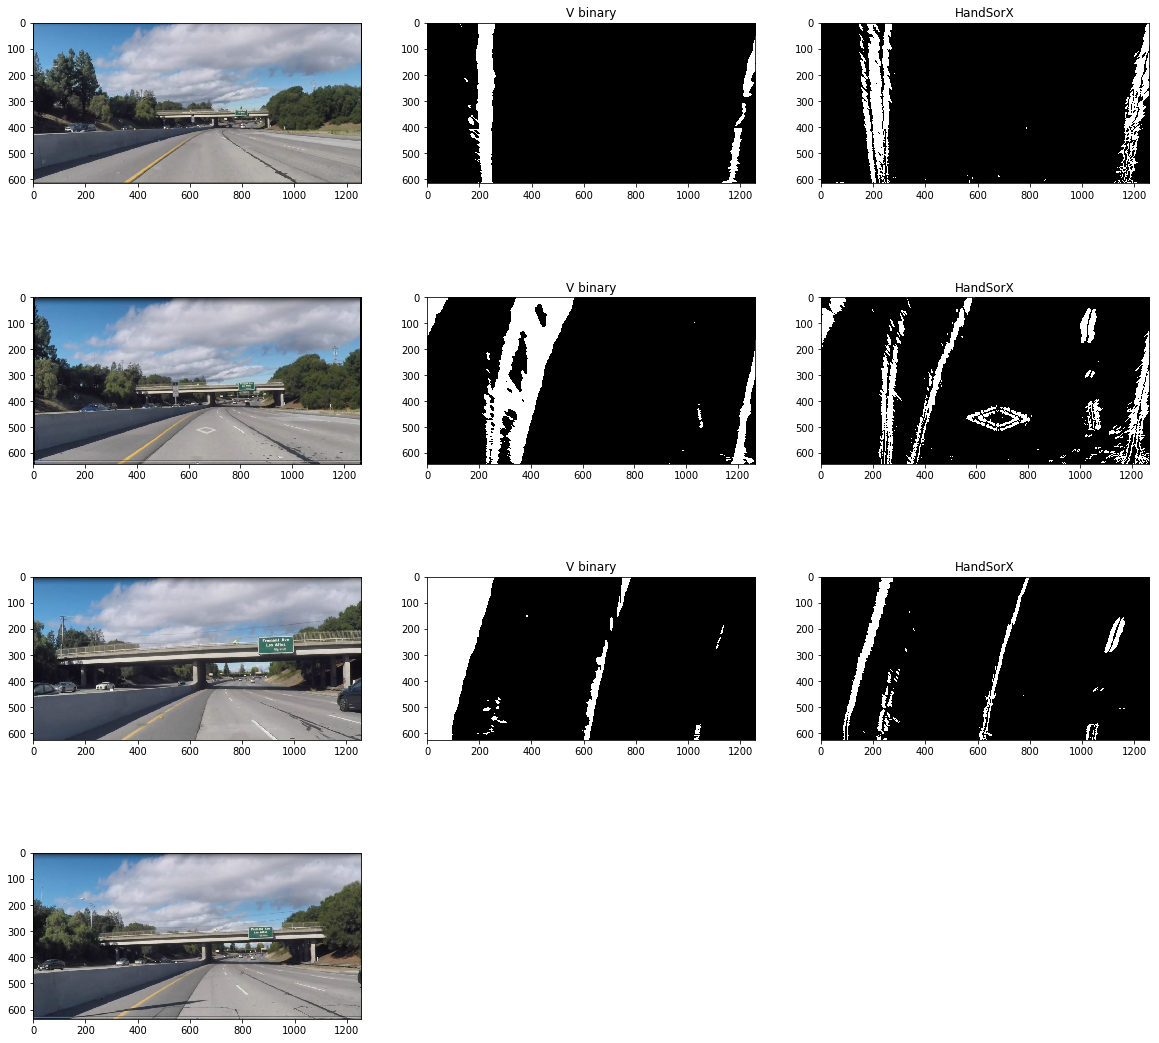

In [25]:
#%matplotlib qt

### DEFAULT PROGRAM TO RUN IMAGES THROUGH

all_test_images = glob.glob('CarND-Advanced-Lane-Lines/test_images/*.jpg')

rows = len(all_test_images)
columns = 2

fig=plt.figure(figsize=(20, 5*rows))
fig_num=1

for index,file_name in enumerate(all_test_images):
    image = mpimg.imread(file_name)
    
    fig.add_subplot(rows, columns, fig_num)
    fig_num+=1
    plt.imshow(image)
    
    final_img1,final_img2 = process_images(image)
    
    fig.add_subplot(rows, columns, fig_num)
    fig_num+=1
    plt.title('V binary')
    plt.imshow(final_img1,cmap='gray')
    
    #fig.add_subplot(rows, columns, fig_num)
    #fig_num+=1
    #plt.title('HandSorX')
    #plt.imshow(final_img2,cmap='gray')

    

    
    


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'CarND-Advanced-Lane-Lines/test_videos_output/harder_challenge_video_output.mp4' #project_video_output #solidYellowLeft

clip1 = VideoFileClip("CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")#.subclip(0,5)#project_video

white_clip = clip1.fl_image(process_images)
#white_clip = clip1.fl_image(lambda image: process_images(image,left_fit,right_fit)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)